In [1]:
import os, random
from os import path
from numpy.random import seed
import keras
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
from PIL import Image
from keras import layers,models
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
from tensorflow import random as tfrandom
import tensorflow as tf
from keras.callbacks import Callback, CSVLogger
import time
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras import backend as K
import math
#from tensorflow import set_random_seed
import cv2

# to assure reproducibility
random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path=os.getcwd()

In [3]:
base_path

'c:\\Users\\Utilizador\\Desktop\\2_semestre_DS\\Deep_Learning\\DL_GroupProject\\DeepLearning_Group_Project'

In [4]:
dir_path=(base_path+r"\tumor_data")

In [28]:
# rename the images to 1_xx, 2_xx, 3_xx, by the labels 

for _, letter in enumerate(os.listdir(dir_path)):
    folder_letter = os.path.join(dir_path, letter)
 
    counts=0
    for _, image in enumerate(os.listdir(folder_letter)):
        
        dst=image
    
        if '_' in dst:
            continue
        else:
            dst = str(letter) + "_" + str(counts) + ".png"
            #print(dst)
            src = os.path.join(folder_letter, image)
            dst = os.path.join(folder_letter, dst)
            print(counts)
            os.rename(src, dst)
            
        counts=counts+1
        

In [7]:
# define directories for the train, val and test splits
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'validation')
test_path = os.path.join(dir_path, 'test')

In [30]:
def createdir(mydir):
    try:
        os.mkdir(mydir)
    except OSError:
        pass

# create the directories

createdir(train_path)
createdir(val_path)
createdir(test_path)

In [31]:
# create the directories for each label for each train, validation and test folders
count=0
for dir in [train_path, val_path, test_path]:
    count+=1
    for letter in ['1','2','3']:
        if count == 1:
            createdir(os.path.join(dir,str("train_{0}".format(str(letter)))))
        elif count == 2:
            createdir(os.path.join(dir,str("val_{0}".format(str(letter)))))   
        elif count == 3:
            createdir(os.path.join(dir,str("test_{0}".format(str(letter)))))
        

In [32]:
# copy all the images for the train folder to then split them for validation and test folders 

count=0

for dir_ in [train_path+r'\train_1', train_path+r'\train_2', train_path+r'\train_3']:
        if len(os.listdir(dir_)) != 0:
            print('break')
            for f in os.listdir(dir_):
                os.remove(os.path.join(dir_, f))
                
for dir in [dir_path+r"\1", dir_path+r"\2", dir_path+r"\3"]:
    count+=1
    
    if count == 1:
        copy_tree(dir, train_path+r'\train_1')
    elif count==2:
        copy_tree(dir, train_path+r'\train_2')
    elif count==3:
        copy_tree(dir, train_path+r'\train_3')

break
break
break


In [6]:
# proportion we want for train, val_test and the test datasets
prop_train=0.80
prop_val_test=0.20
prop_test=0.50 

In [34]:
labels={'label1':708,'label2':1426,'label3':930}

In [35]:
# input images in VALIDATION

count=0
for index, letter in enumerate(os.listdir(train_path)):
    count+=1
    folder_letter_source = os.path.join(train_path, letter)
    folder_letter_destiny_val = os.path.join(val_path, str("val_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_val_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_val)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_val):
                os.remove(os.path.join(folder_letter_destiny_val, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_val, image)
        shutil.move(src, dst)


break
break
break


In [36]:
labels['label1']=round(labels['label1']*prop_val_test)
labels['label2']=round(labels['label2']*prop_val_test)
labels['label3']=round(labels['label3']*prop_val_test)
labels

{'label1': 142, 'label2': 285, 'label3': 186}

In [37]:
# input images in TEST

count=0
for index, letter in enumerate(os.listdir(val_path)):
    count+=1
    folder_letter_source = os.path.join(val_path, letter)
    folder_letter_destiny_test = os.path.join(test_path, str("test_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_test)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_test):
                os.remove(os.path.join(folder_letter_destiny_test, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_test, image)
        shutil.move(src, dst)
        

break
break
break


In [18]:
train_datagen_aug=ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=50,
                    rotation_range=10,
                    shear_range=0.05)
                    #horizontal_flip=True )

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 2451 images belonging to 3 classes.


In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [10]:
train_generator_rgb = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
)

val_generator_rgb = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
)

test_generator_rgb = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [13]:
def save_times(model, times,name_model):
  
    times_dict = {'Model': ['Model {}'.format(str(name_model))]}
    for idx, time in enumerate(times):
        times_dict[idx] = times[idx]
    df_save_times = pd.DataFrame(times_dict)

    if os.path.exists(r'.\models\models_times.csv'):
        df_save_times.to_csv(r'.\models\models_times.csv', mode='a', header=False, index=False)
    else:
        df_save_times.to_csv(r'.\models\models_times.csv')

In [14]:
def plot_history(his):
    f1 = his['f1_m']
    f1_val=his['val_f1_m']
    loss = his['loss']
    loss_val=his['val_loss']

    epochs=range(1,len(f1)+1)

    plt.plot(epochs, f1,'bo',label='Training F1')
    plt.plot(epochs, f1_val,'b',label='Validation F1')
    plt.title('Training and Validation F1 score')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss,'bo',label='Training loss')
    plt.plot(epochs, loss_val,'b',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

In [35]:
def callback(filename):
  callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True)
            ,time_callback]

  return callname_list

In [26]:
BATCH_SIZE=20 
TRAINING_SIZE = 2451 
VALIDATION_SIZE = 307 

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE)) 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE) 
val_steps = compute_steps_per_epoch(VALIDATION_SIZE) 

print(steps_per_epoch)
print(val_steps)

123
16


In [16]:
dependencies = {
    'f1_m': f1_m
}

In [28]:
callbacks_BW = callback("\modelBW.h5")

In [29]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.8476 - f1_m: 0.4821
Epoch 00001: val_loss improved from inf to 0.66116, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 113s 918ms/step - loss: 0.8476 - f1_m: 0.4821 - val_loss: 0.6612 - val_f1_m: 0.6964
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.6195 - f1_m: 0.7136
Epoch 00002: val_loss improved from 0.66116 to 0.55743, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 110s 897ms/step - loss: 0.6195 - f1_m: 0.7136 - val_loss: 0.5574 - val_f1_m: 0.7547
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4924 - f1_m: 0.7831
Epoch 00003: val_loss did not improve from 0.55743
123/123 [==============================] - 11

In [30]:
np.save('models/historyBW.npy',history_1st.history)
modelBW = keras.models.load_model('models/modelBW.h5', custom_objects=dependencies)
historyBW=np.load('models/historyBW.npy',allow_pickle='TRUE').item()
timesBW = time_callback.times
save_times(modelBW, timesBW,'modelBW')

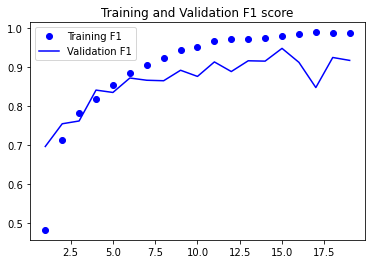

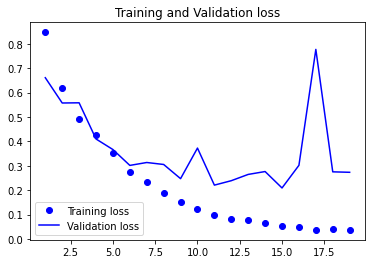

<Figure size 432x288 with 0 Axes>

In [31]:
plot_history(historyBW)

In [17]:
callbacks_BW_inc = callback("\modelBW_inc.h5")
#increase the nr of filters through the CNN

In [38]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_2 = model2.fit_generator(train_generator, callbacks=callbacks_BW_inc, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.8051 - f1_m: 0.5324
Epoch 00001: val_loss improved from inf to 0.63319, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 71s 576ms/step - loss: 0.8051 - f1_m: 0.5324 - val_loss: 0.6332 - val_f1_m: 0.6955
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5951 - f1_m: 0.7319
Epoch 00002: val_loss improved from 0.63319 to 0.57052, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 58s 470ms/step - loss: 0.5951 - f1_m: 0.7319 - val_loss: 0.5705 - val_f1_m: 0.6973
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4877 - f1_m: 0.7917
Epoch 00003: val_loss improved from 0.57052 to 0.52632, saving model to c:\Users\Utilizado

In [39]:
np.save('models/historyBW_inc.npy',history_2.history)
modelBW_inc = keras.models.load_model('models/modelBW_inc.h5', custom_objects=dependencies)
historyBW_inc=np.load('models/historyBW_inc.npy',allow_pickle='TRUE').item()
timesBW = time_callback.times
save_times(modelBW_inc, timesBW,'modelBW_inc')

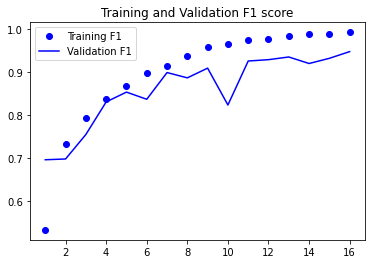

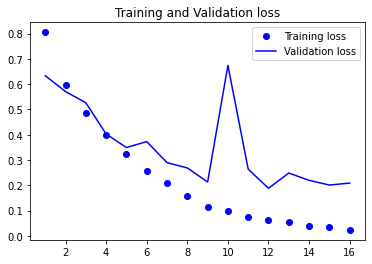

<Figure size 432x288 with 0 Axes>

In [40]:
plot_history(historyBW_inc)

# REDUCING THE NUMBER OF LAYERS

In [41]:
callbacks_BW_simple = callback("\modelBW_simple.h5")
#increase the nr of filters through the CNN

In [42]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_3 = model3.fit_generator(train_generator, callbacks=callbacks_BW_simple, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7673 - f1_m: 0.5921
Epoch 00001: val_loss improved from inf to 0.65803, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 76s 619ms/step - loss: 0.7673 - f1_m: 0.5921 - val_loss: 0.6580 - val_f1_m: 0.7235
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5336 - f1_m: 0.7644
Epoch 00002: val_loss improved from 0.65803 to 0.47772, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 69s 563ms/step - loss: 0.5336 - f1_m: 0.7644 - val_loss: 0.4777 - val_f1_m: 0.7817
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.3725 - f1_m: 0.8408
Epoch 00003: val_loss improved from 0.47772 to 0.40945, saving model to c:\Users\Uti

In [43]:
np.save('models/historyBW_simple.npy',history_3.history)
modelBW_simple = keras.models.load_model('models/modelBW_simple.h5', custom_objects=dependencies)
historyBW_simple=np.load('models/historyBW_simple.npy',allow_pickle='TRUE').item()
timesBW_simple = time_callback.times
save_times(modelBW_simple, timesBW_simple,'modelBW_simple')

# DATA AUGMENTATION AND DROP OUT 0.5

In [36]:
callbacks_BW_aug_5 = callback("\modelBW_aug_5.h5")
# aug and dropout
# modelBW_aug_rot= rotation10
# modelBW_aug=rot50

In [37]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_4 = model4.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_5, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7921 - f1_m: 0.5610
Epoch 00001: val_loss improved from inf to 0.60428, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 87s 704ms/step - loss: 0.7921 - f1_m: 0.5610 - val_loss: 0.6043 - val_f1_m: 0.7310
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5858 - f1_m: 0.7290
Epoch 00002: val_loss improved from 0.60428 to 0.53367, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 87s 704ms/step - loss: 0.5858 - f1_m: 0.7290 - val_loss: 0.5337 - val_f1_m: 0.7661
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4972 - f1_m: 0.7857
Epoch 00003: val_loss did not improve from 0.53367
123/123 [==========================

In [38]:
np.save('models/historyBW_aug_5.npy',history_4.history)
modelBW_aug_5 = keras.models.load_model('models/modelBW_aug_5.h5', custom_objects=dependencies)
historyBW_aug_5=np.load('models/historyBW_aug_5.npy',allow_pickle='TRUE').item()
timesBW_aug_5 = time_callback.times
save_times(modelBW_aug_5, timesBW_aug_5,'modelBW_aug_5')

In [59]:
preds = modelBW_aug_5.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW_aug_5.evaluate_generator(test_generator)
cm

array([[ 65,   3,   3],
       [ 11, 130,   1],
       [  1,   0,  92]], dtype=int64)

In [60]:
print(f'Test loss: {test_score[0]} / Test accuracy: {test_score[1]}')

Test loss: 0.23228779435157776 / Test accuracy: 0.9333332777023315


# DATA AUGMENTATION with class_weights


In [71]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def generate_class_weights(class_series):

  # If class is one hot encoded, transform to categorical labels to use compute_class_weight   

  class_series = np.argmax(class_series, axis=1)

  # Compute class weights with sklearn method
  class_labels = np.unique(class_series)
  class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
  return dict(zip(class_labels, class_weights))


In [146]:
#train_generator_aug.
one_hot_labels = next(train_generator)[1]
class_series = np.argmax(one_hot_labels, axis=1)

# Compute class weights with sklearn method
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
# class_weights=generate_class_weights(one_hot_labels)

In [148]:
one_hot_labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
callbacks_BW_aug_5 = callback("\modelBW_aug_5.h5")
# aug and dropout
# modelBW_aug_rot= rotation10
# modelBW_aug=rot50

# DATA AUGMENTATION AND DROP OUT 0.5

In [ ]:
callbacks_BW_aug_5 = callback("\modelBW_aug_5.h5")
# aug and dropout
# modelBW_aug_rot= rotation10
# modelBW_aug=rot50

In [ ]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_4 = model4.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_5, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7921 - f1_m: 0.5610
Epoch 00001: val_loss improved from inf to 0.60428, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 87s 704ms/step - loss: 0.7921 - f1_m: 0.5610 - val_loss: 0.6043 - val_f1_m: 0.7310
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5858 - f1_m: 0.7290
Epoch 00002: val_loss improved from 0.60428 to 0.53367, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 87s 704ms/step - loss: 0.5858 - f1_m: 0.7290 - val_loss: 0.5337 - val_f1_m: 0.7661
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4972 - f1_m: 0.7857
Epoch 00003: val_loss did not improve from 0.53367
123/123 [==========================

In [ ]:
np.save('models/historyBW_aug_5.npy',history_4.history)
modelBW_aug_5 = keras.models.load_model('models/modelBW_aug_5.h5', custom_objects=dependencies)
historyBW_aug_5=np.load('models/historyBW_aug_5.npy',allow_pickle='TRUE').item()
timesBW_aug_5 = time_callback.times
save_times(modelBW_aug_5, timesBW_aug_5,'modelBW_aug_5')

In [ ]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_4 = model4.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_5, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7921 - f1_m: 0.5610
Epoch 00001: val_loss improved from inf to 0.60428, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 87s 704ms/step - loss: 0.7921 - f1_m: 0.5610 - val_loss: 0.6043 - val_f1_m: 0.7310
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5858 - f1_m: 0.7290
Epoch 00002: val_loss improved from 0.60428 to 0.53367, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 87s 704ms/step - loss: 0.5858 - f1_m: 0.7290 - val_loss: 0.5337 - val_f1_m: 0.7661
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4972 - f1_m: 0.7857
Epoch 00003: val_loss did not improve from 0.53367
123/123 [==========================

In [ ]:
np.save('models/historyBW_aug_5.npy',history_4.history)
modelBW_aug_5 = keras.models.load_model('models/modelBW_aug_5.h5', custom_objects=dependencies)
historyBW_aug_5=np.load('models/historyBW_aug_5.npy',allow_pickle='TRUE').item()
timesBW_aug_5 = time_callback.times
save_times(modelBW_aug_5, timesBW_aug_5,'modelBW_aug_5')

# TRANSFER LEARNING

In [15]:
pre_trained=tf.keras.applications.resnet50.ResNet50(
                                                    include_top=True,
                                                    input_shape=(150,150,1),
                                                    weights='imagenet',
                                                    input_tensor=None,
                                               
                                                    pooling=None,
                                                    classes=1000
                                                )

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

In [16]:
base_model = keras.applications.ResNet50(
                                        weights='imagenet',  
                                        input_shape=(150, 150, 3),
                                   
                                        include_top=False)  

In [17]:
callbacks_trans = callback("\model_trans.h5")

In [18]:
# from keras.models import Model
# from keras.layers import Input 

# resnet = keras.applications.ResNet50(weights='imagenet',include_top='FALSE') 

# input_tensor = Input(shape=(150,150,1) )
# x = layers.Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
# out = resnet (x) 

# model_trans = keras.Model(inputs=input_tensor,outputs=out)


base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalMaxPooling2D()(x)
outputs = keras.layers.Dense(3)(x)
model_trans = keras.Model(inputs, outputs)
model_trans.compile(loss='categorical_crossentropy', optimizer="adam", metrics = [f1_m])

In [77]:
# # callbacks

# # lr_reduce = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=23)
# mc = ModelCheckpoint('MODEL_trans.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

In [20]:
# Epochs
epochs = 20
# Batch size
hist_trans = model_trans.fit(train_generator_rgb,
                            epochs = epochs,
                            validation_data = val_generator_rgb,
                            callbacks=callbacks_trans, workers=2)

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 8.2735 - f1_m: 0.4659
Epoch 00001: val_loss improved from inf to 8.61032, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 254s 2s/step - loss: 8.2735 - f1_m: 0.4659 - val_loss: 8.6103 - val_f1_m: 0.4527
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 8.6147 - f1_m: 0.4655
Epoch 00002: val_loss improved from 8.61032 to 8.61032, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 211s 2s/step - loss: 8.6147 - f1_m: 0.4655 - val_loss: 8.6103 - val_f1_m: 0.4585
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 8.6147 - f1_m: 0.4652
Epoch 00003: val_loss did not improve from 8.61032
123/123 [==============================] - 

KeyboardInterrupt: 

In [73]:
preds = modelBW.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW.evaluate_generator(test_generator)

C:\Users\filip\AppData\Local\Temp/ipykernel_7176/1856620179.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = modelBW.evaluate_generator(test_generator)


In [74]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        71
           1       0.92      0.97      0.95       142
           2       0.97      0.97      0.97        93

    accuracy                           0.94       306
   macro avg       0.94      0.92      0.93       306
weighted avg       0.94      0.94      0.94       306



In [ ]:
#modelBW.summary()

In [ ]:
# test_score_modelBW = modelBW.evaluate_generator(test_generator)
# test_score_modelBW

In [ ]:
# Modelo sem aug BW
#  ---- dropout augmentation

# Modelo sem aug RGB
#  ---- dropout augmentation

# funçoes dos plots

# time function comparison